# Assignment 2 

### MACS 30000, Dr. Evans

### Siyuan Peng

In [1]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#Turn off Notebook Package Warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Imputing age and gender

#### (a) 
Considering that these two data bases share two variables, which are income and weight, we could use these two variables as explanatory variables to build model with age and gender using survey income database. To be specifc, that is:

$age = \alpha_0 + \alpha_1 * weight + \alpha_2 * tot\_inc + \epsilon$

$female = \beta_0 + \beta_1  weight + \beta_2 * tot\_inc + \epsilon$

Then, we could use the result of $\alpha$ and $\beta$ to calculate the age and gender in best income database.

#### (b) 
First, I must import the data.

In [2]:
# I may use this code cell to read in my data and name the variables which have been defined in the 'Assign2.pdf'.
best_income = pd.read_csv('BestIncome.txt', header = None)
best_income.columns = ['lab_inc', 'cap_inc', 'hgt', 'wgt']

survey_income = pd.read_csv('SurvIncome.txt', header = None)
survey_income.columns = ['tot_inc', 'wgt', 'age', 'female']

In [3]:
# I shall start with the age model, which should be a simple OLS regression model.
Y1 = survey_income['age']
survey_income['cons'] = 1
X1 = survey_income[['wgt', 'tot_inc', 'cons']]
ols = sm.OLS(Y1, X1,).fit()

#Use the ols result to calculate the age of the BestIncome database.
best_income['tot_inc'] = best_income['lab_inc'] + best_income['cap_inc']
best_income['cons'] = 1
best_income['age'] = ols.predict(best_income[['wgt', 'tot_inc', 'cons']])

In [4]:
# Secondly, I shall compute the gender model. Considering that gender is a 0\1 variable, we need to use logit model to dealing with it.
Y2 = survey_income['female']
X2 = survey_income[['wgt', 'tot_inc', 'cons']]
logit = sm.Logit(Y2,X2).fit()

#Use the logit result to calculate the gender of the BestIncome database.
best_income['female'] = logit.predict(best_income[['wgt', 'tot_inc', 'cons']])

#Check the value of the gender variable.
check = best_income['female'][:]
check[check >= 0.5] = 1
check[check < 0.5] = 0
best_income['female'] = check

Optimization terminated successfully.
         Current function value: 0.036050
         Iterations 11


#### (c)
The report of the variables are listed below.

In [5]:
# Firstly, report the age.
print(best_income['age'].describe()[['mean', 'std', 'min', 'max', 'count']])

#Secondly, report the gender.
print(best_income['female'].describe()[['mean', 'std', 'min', 'max', 'count']])

mean        44.890828
std          0.219150
min         43.976495
max         45.703819
count    10000.000000
Name: age, dtype: float64
mean         0.454600
std          0.497959
min          0.000000
max          1.000000
count    10000.000000
Name: female, dtype: float64


#### (d)
The correlation matrix is shown below.

In [6]:
show_list = best_income[['lab_inc','cap_inc','hgt','wgt','age','female']]
cor = show_list.corr()
cor.style.background_gradient()

,lab_inc,cap_inc,hgt,wgt,age,female
lab_inc,1,0.0053253,0.00278978,0.00450691,0.924053,-0.215469
cap_inc,0.0053253,1,0.0215716,0.00629868,0.234159,-0.0625691
hgt,0.00278978,0.0215716,1,0.172103,-0.0450828,-0.127416
wgt,0.00450691,0.00629868,0.172103,1,-0.300288,-0.763821
age,0.924053,0.234159,-0.0450828,-0.300288,1,0.0200595
female,-0.215469,-0.0625691,-0.127416,-0.763821,0.0200595,1


### 2. Imputing age and gender

#### (a) 
Just compute the raw data.

In [7]:
# I may use this code cell to read in my data and name the variables which have been defined in the 'Assign2.pdf'.
income_intel = pd.read_csv('IncomeIntel.txt', header = None)
income_intel.columns = ['grad_year', 'gre_qnt', 'salary_p4']

In [8]:
# Then, I shall simply compute the raw data use the OLS model as stated in the assignment.
Y1 = income_intel['salary_p4']
income_intel['cons'] = 1
X1 = income_intel[['gre_qnt', 'cons']]
ols = sm.OLS(Y1,X1).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              salary_p4   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     356.3
Date:                Tue, 16 Oct 2018   Prob (F-statistic):           3.43e-68
Time:                        17:52:49   Log-Likelihood:                -10673.
No. Observations:                1000   AIC:                         2.135e+04
Df Residuals:                     998   BIC:                         2.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gre_qnt      -25.7632      1.365    -18.875      0.0

As shown above, the coefficient of GRE quantitative score is -25.7632 and its standard error is 1.365.
As for the coefficient of cons, it is 8.954 * 10^4 and its standard error is 878.764.

#### (b) 
Draw the scatterplot and find the problem.

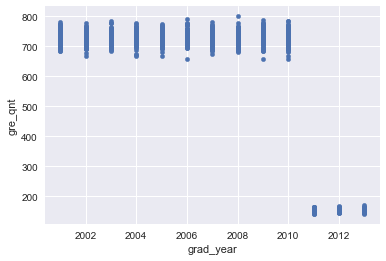

In [9]:
# draw the scatterplot.
income_intel.plot(x = 'grad_year', y = 'gre_qnt', kind = 'scatter')
plt.show()

Here is where I'll discuss any problems that jump out. I'll propose a solution here as well.

The above scatterplot shows clearly that the GRE quatitative score changed dramatically after 2011. Considering that the scale of this score has changed in 2011, we could use the concordance table provided by the official ETS to transform the old score to the latest version to make sure our regression is consistent.

The link of the concordance table is : https://www.ets.org/s/gre/pdf/concordance_information.pdf

#### (c) 
Draw the scatterplot and find the problem.

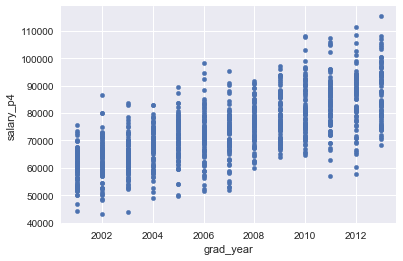

In [10]:
# draw the scatterplot.
income_intel.plot(x = 'grad_year', y = 'salary_p4', kind = 'scatter')
plt.show()

The scatterplot shows clearly that there is a increasing trend of salary acrossing years. Therefore, we need to detrend the salary firstly. 
The solution will be shown as follows:
(1) Treat the first year of the data, which is 2001, equal to the base year.
(2) Calculate the average growth rate in salary.
(3) Divide each salary by the (1 + avg_growth_rate) ** (grad_year - 2001). 
All of the equations related to this method are provided by Professor Evans.

#### (d) 
Re-estimate.

In [11]:
# Use the concordance table to transform the old score to the latest version.
def concordance(qnt_score):
    old_version = [800, 790, 780, 770, 760, 750, 740, 730, 720, 710, 690, 680, 670, 650, 630, 620, 600, 580, 560, 540, 520, 490, 470, 450, 420, 390, 370, 340, 320, 290, 270, 250, 230, 210, 200]
    lat_version = [166, 164, 163, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130]
    if qnt_score < 171:
        return qnt_score
    else:
        for i,val in enumerate(lat_version):
            if qnt_score <= old_version[i] and qnt_score > old_version[i+1]:
                return val

income_intel['lat_score'] = [[]] * len(income_intel['gre_qnt'])
for i in range(len(income_intel['lat_score'])):
    income_intel['lat_score'][i] = concordance(income_intel['gre_qnt'][i])

# Calculate the detrend salary.
avg_inc_by_year = income_intel['salary_p4'].groupby(income_intel['grad_year']).mean().values
avg_growth_rate = ((avg_inc_by_year[1:] - avg_inc_by_year[:-1]) / avg_inc_by_year[:-1]).mean()
income_intel['det_salary'] = [[]] * len(income_intel['salary_p4'])
for i in range(2001, 2014):
    income_intel['det_salary'][income_intel['grad_year'] == i] = income_intel['salary_p4']/(1 + avg_growth_rate) ** (i - 2001)

# Calculate the new OLS model.
Y2 = income_intel['det_salary']
X2 = income_intel[['lat_score', 'cons']]
ols = sm.OLS(Y2.astype(float),X2.astype(float)).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:             det_salary   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4730
Date:                Tue, 16 Oct 2018   Prob (F-statistic):              0.492
Time:                        17:53:27   Log-Likelihood:                -10291.
No. Observations:                1000   AIC:                         2.059e+04
Df Residuals:                     998   BIC:                         2.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lat_score    -46.0587     66.967     -0.688      0.4

The above result shows that while the coefficient of the GRE quantitative score is still negative, it becomes insiginificant.

In our common sense, person who has higher mathmatics score should has higher salary. However, the result of our original model conflicts this common sense. Therefore, when we modify our model by use the same scale of the GRE score and detrend salary, even though the coefficient is still negative, it becomes insiginificant, which means that there is no relationship between GRE score and salary. I think we could see this change as a improvement. At least the model doesn't conflict our common sense now.

As for the reason for this relatively small R^2 and insignificant coefficient, I think it is mainly due to the fact that mathmatic score doesn't have a linear relationship with salary at all.

### 3. Assessment of Kossinets and Watts.

See attached PDF. 